# The implementation and visualization of our sampling method

For simplicity, we start from after obtained the feature map of the images.

If you are interested in how we obtain the feature map, please refer to the visualization_logging.ipynb. We leverage the finetuned polyp-PVT model to extract the feature map of the images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

## Implementation of our sampling method

In [2]:
# the implementation of the sample selection strategy

def euclidean_distance_matrix(X, Y):
    """计算两组点之间的欧氏距离矩阵。"""
    D = np.sqrt(((X[:, np.newaxis, :] - Y[np.newaxis, :, :]) ** 2).sum(axis=2))
    return D

def load_feature_map(feature_map_dir, name_list=None):
    # load the feature map
    feature_map_dir_1 = os.path.join(feature_map_dir, 'original')
    feature_map_dir_0 = os.path.join(feature_map_dir, 'synthetic')

    feature_map_files_1 = os.listdir(feature_map_dir_1)
    feature_map_files_0 = os.listdir(feature_map_dir_0)

    feature_map_original = []
    feature_map_synthetic = []

    # only load the selected synthetic data (the qualified synthetic data)
    for file in feature_map_files_1:
        feature_map_original.append(np.load(os.path.join(feature_map_dir_1, file)))
    for file in feature_map_files_0:
        if name_list is None:
            raise ValueError("name_list of align cases should not be None")
        else:
            if file.split(".")[0] in name_list:
                feature_map_synthetic.append(np.load(os.path.join(feature_map_dir_0, file)))
    
    feature_map_original = np.array(feature_map_original)
    feature_map_synthetic = np.array(feature_map_synthetic)
    
    return feature_map_original, feature_map_synthetic

# save the distance matrix
def save_data_distance_matrix(feature_map_original, feature_map_synthetic, output_dir):
    # calculate the distance matrix
    dist_to_real = euclidean_distance_matrix(feature_map_synthetic, feature_map_original)
    dist_to_synthetic = euclidean_distance_matrix(feature_map_synthetic, feature_map_synthetic)
    # save the distance matrix
    np.save(os.path.join(output_dir, 'dist_to_real.npy'), dist_to_real)
    np.save(os.path.join(output_dir, 'dist_to_synthetic.npy'), dist_to_synthetic)
    
# our sample selection strategy
def select_synthetic_data(data, synthetic_data, dist_to_real_path, dist_to_synthetic_path, name_list, num_samples):
    n_synthetic = synthetic_data.shape[0]
    n_data = data.shape[0]

    # 预计算距离矩阵
    dist_to_real = np.load(dist_to_real_path)
    dist_to_synthetic = np.load(dist_to_synthetic_path)

    # take the point with maximun distance to the real data as initial point
    initial_index = np.argmax(dist_to_real.mean(axis=1))
    selected_indices = [initial_index]
    
    while len(selected_indices) < num_samples:
        remaining_indices = list(set(range(n_synthetic)) - set(selected_indices))
        
        # 计算到真实样本的平均距离和到已选合成样本的平均距离
        avg_dist_to_real = dist_to_real[remaining_indices, :].mean(axis=1)
        avg_dist_to_selected = dist_to_synthetic[np.ix_(remaining_indices, selected_indices)].mean(axis=1)
        
        # 选择平均距离之和最大的点
        sum_distances = avg_dist_to_real + avg_dist_to_selected
        next_index = remaining_indices[np.argmax(sum_distances)]
        selected_indices.append(next_index)

    # we will sampling the synthetic data with the selected indices
    return selected_indices, [name_list[i] for i in selected_indices]


In [3]:
# application in our data

data_csv = "data/1_data.csv"
data_csv = pd.read_csv(data_csv)
# all synthetic data should be include
names = data_csv['name'].tolist()

# load feature map
feature_map_original, feature_map_synthetic = load_feature_map("feature_maps", name_list=names)
# calculate the distance matrix
save_data_distance_matrix(feature_map_original, feature_map_synthetic, "feature_maps")

# load the distance matrix
dist_to_real_path = "feature_maps/dist_to_real.npy"
dist_to_synthetic_path = "feature_maps/dist_to_synthetic.npy"

# running the sample selection strategy
selected_indices, name_in_order = select_synthetic_data(feature_map_original, feature_map_synthetic, dist_to_real_path, dist_to_synthetic_path, name_list=names, num_samples=len(names))
print(len(name_in_order))

# update the order of sampling
data_csv = "data/1_data.csv"
data_csv = pd.read_csv(data_csv)
for i in range(len(name_in_order)):
    data_csv.loc[data_csv['name'] == name_in_order[i], 'priority'] = i
data_csv.to_csv("data/1_data.csv", index=False)

1993


## Visualization of the feature map obtain by different sampling methods

In [4]:
# visualize the feature map with t-SNE
from sklearn.manifold import TSNE
import seaborn as sns


def visualize_distribution(feature_map_dir="feature_maps", 
                           name_list = None,
                           output_name = 'feature_map_tsne.png'):
    """_summary_

    Args:
        feature_map_dir (str): the root directory of the feature maps
        name_list (list): the list of the selected synthetic images
        output_name (str): the name of the output figure
    """

    # the original feature map folder
    feature_map_dir_original = os.path.join(feature_map_dir, 'original')
    # the synthetic feature map folder
    feature_map_dir_synthetic = os.path.join(feature_map_dir, 'synthetic')

    feature_map_files_original = os.listdir(feature_map_dir_original)
    feature_map_files_synthetic = os.listdir(feature_map_dir_synthetic)

    feature_map_original = []
    feature_map_synthetic = []
    feature_map_selected = []

    # load the feature maps for the original images
    for file in feature_map_files_original:
        feature_map_original.append(np.load(os.path.join(feature_map_dir_original, file)))
        
        
    # load the feature maps
    for file in feature_map_files_synthetic:
        if name_list is None:
            feature_map_synthetic.append(np.load(os.path.join(feature_map_dir_synthetic, file)))
        else:
            # only load the feature maps for the selected synthetic images
            if file.split(".")[0] in name_list:
                feature_map_selected.append(np.load(os.path.join(feature_map_dir_synthetic, file)))
            else:
                # load the feature maps for the rest of the synthetic images (unselected)
                feature_map_synthetic.append(np.load(os.path.join(feature_map_dir_synthetic, file)))

    feature_map_original = np.array(feature_map_original)
    feature_map_synthetic = np.array(feature_map_synthetic)
    feature_map_selected = np.array(feature_map_selected)

    # for no selected synthetic images cases
    if len(feature_map_selected) == 0:
        feature_map = np.concatenate([feature_map_original, feature_map_synthetic], axis=0)
        labels = ["original"] * len(feature_map_original) + ["synthetic"] * len(feature_map_synthetic)
    
    # for selected synthetic images cases
    else:
        feature_map = np.concatenate([feature_map_original, feature_map_synthetic, feature_map_selected], axis=0)
        labels = ["original"] * len(feature_map_original) + ["synthetic"] * len(feature_map_synthetic) + ["selected"] * len(feature_map_selected)

    # t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    feature_map_tsne = tsne.fit_transform(feature_map)

    feature_map_tsne = pd.DataFrame(feature_map_tsne, columns=['x', 'y'])
    feature_map_tsne['label'] = labels

    plt.figure(figsize=(10, 10))
    sns.scatterplot(x='x', y='y', hue='label', data=feature_map_tsne)
    plt.savefig(os.path.join(feature_map_dir, output_name))
    plt.show()


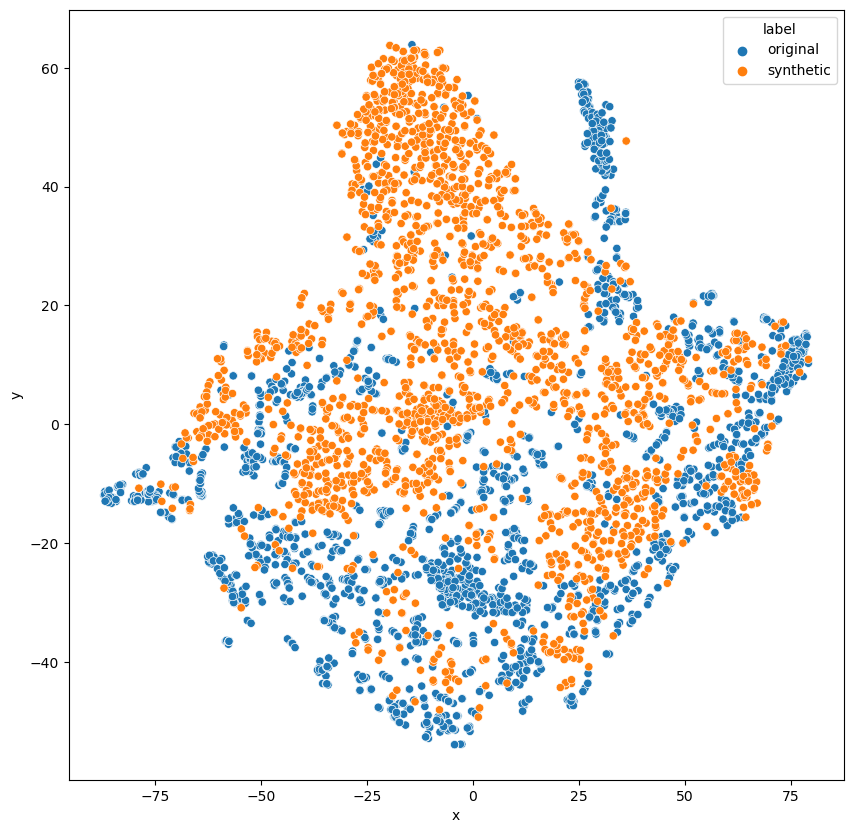

In [5]:
# visualize the distribution of the feature maps of the original and synthetic images
visualize_distribution()

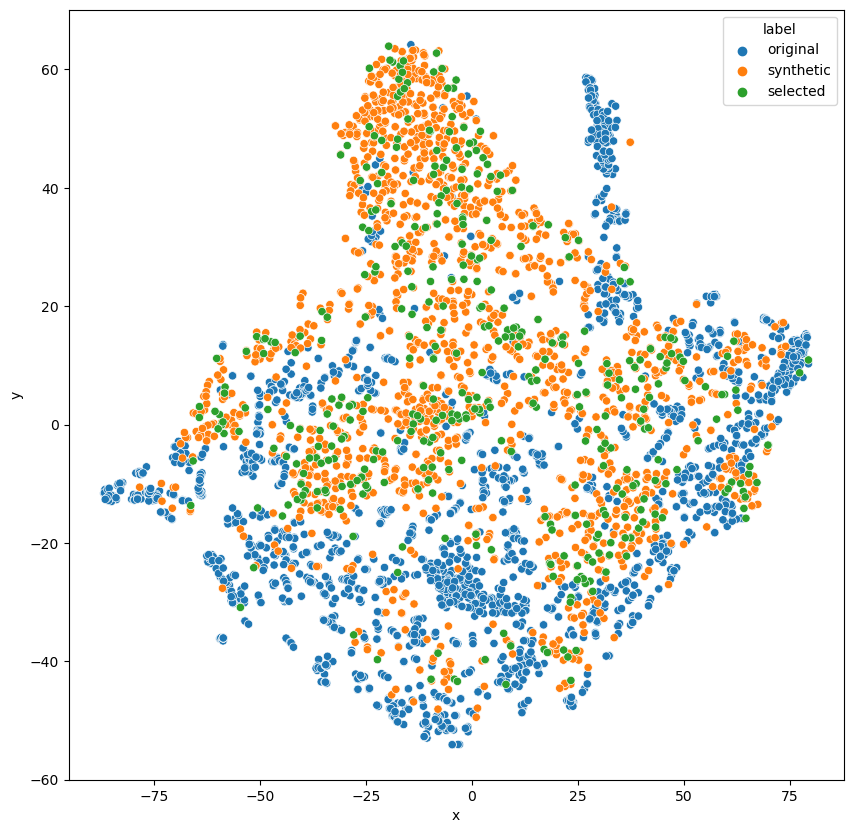

In [6]:
# visualization of the random selected synthetic images
data_csv = "data/1_data.csv"
max_num = 400

data_csv = pd.read_csv(data_csv)
filter_data = data_csv[data_csv['alignment_score'] > 0.8] # filter the data with alignment score > 0.8, qualified cases
sample_data = filter_data.sample(n=max_num, random_state=0)
names = sample_data['name'].tolist()

visualize_distribution(name_list=names, output_name='feature_map_tsne_random.png')

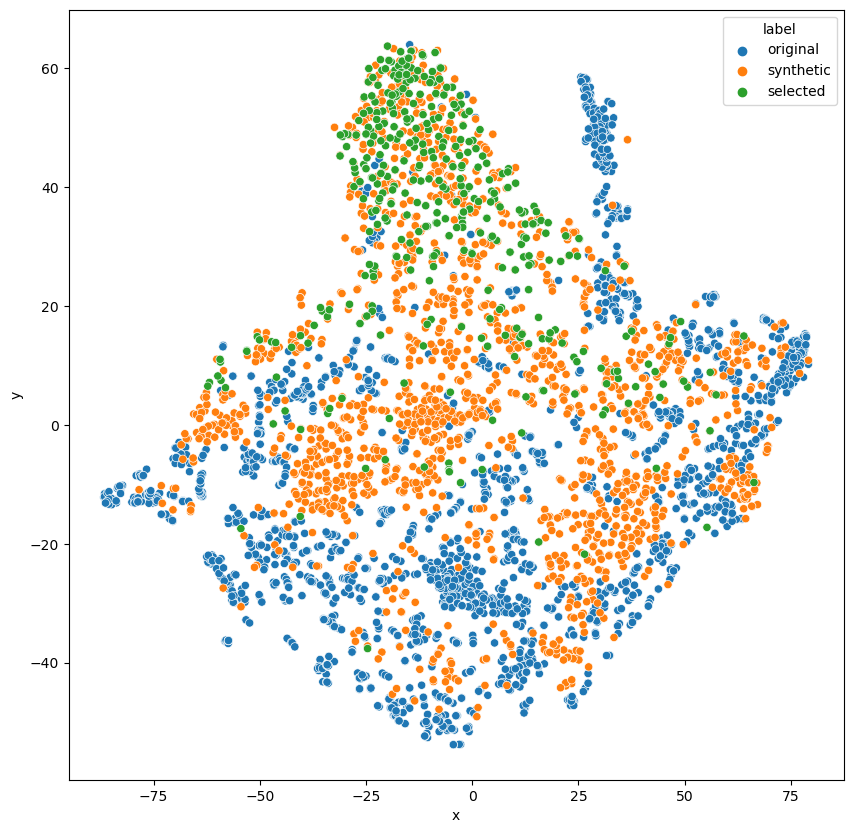

In [7]:
# visualization of the prediction based selected synthetic images
data_csv = "data/1_data.csv"
max_num = 400

data_csv = pd.read_csv(data_csv)
filter_data = data_csv[data_csv['alignment_score'] > 0.8]
sample_data = filter_data.sort_values(by='prediction_score', ascending=True).head(max_num)
names = sample_data['name'].tolist()

visualize_distribution(name_list=names, output_name='feature_map_tsne_prediction.png')

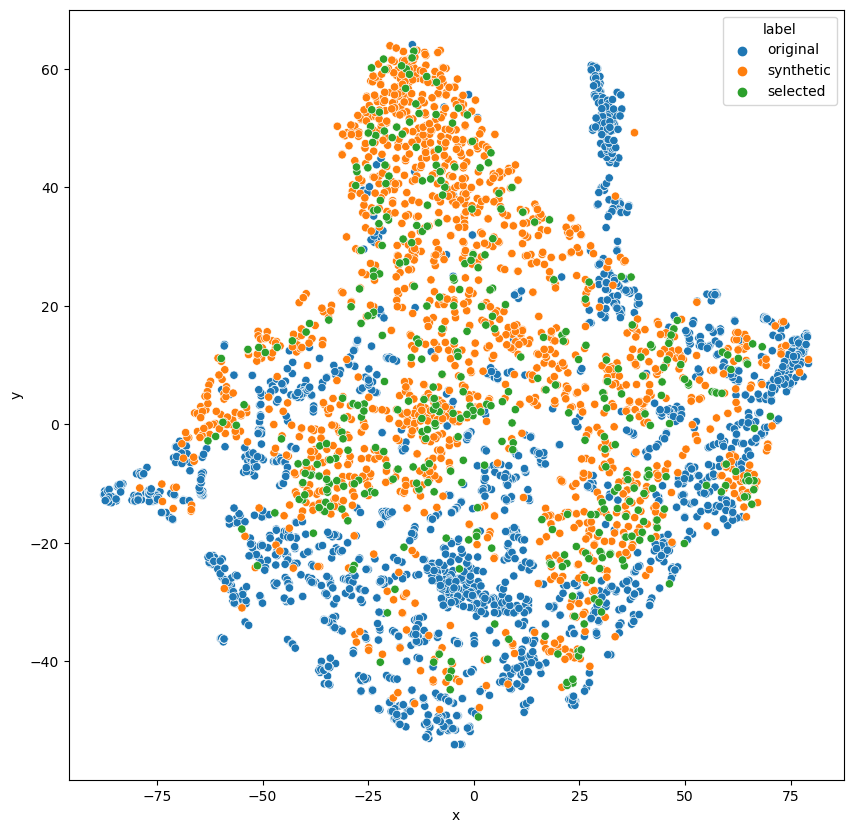

In [8]:
filter_data = data_csv[data_csv['alignment_score'] > 0.8]
sample_data = filter_data.sort_values(by='priority', ascending=True).head(400)
names = sample_data['name'].tolist()
visualize_distribution(name_list=names, output_name='feature_map_tsne_distance.png')

## Summary of the model performance with different sampling methods

In [12]:
import re
# summary of the result
# 4 digits after the decimal point
pd.set_option('display.float_format', '{:.4f}'.format)

def get_prediction_result(pred_path, method):
    with open(pred_path, "r") as f:
        pred = f.read()
    dice_values = np.array(re.findall(r'dice is : (\d+\.\d+)', pred)).astype(float)[:4]
    # add the mean to the last row
    dice_values = np.append(dice_values, np.mean(dice_values))
    datasets = ["SUN-SEG_10_test", "Kvasir-SEG", "CVC-ClinicDB", "CVC-ColonDB", "Overall"]
    methods = [method] * len(datasets)
    dicts = {"Dataset": datasets, "Sample Method": methods, "Dice": dice_values}
    return pd.DataFrame(dicts)

# get the prediction result of different sample method
baseline_path = "logs/test/baseline/baseline.log"
ramdon_400_path = "logs/test/aug/random_400.log"
prediction_400_path = "logs/test/aug/prediction_400.log"
priority_400_path = "logs/test/aug/ours_400.log"

baseline_result = get_prediction_result(baseline_path, "Baseline")
ramdon_400_result = get_prediction_result(ramdon_400_path, "Random")
prediction_400_result = get_prediction_result(prediction_400_path, "Prediction")
priority_400_result = get_prediction_result(priority_400_path, "Distance")

combine_result = pd.concat([baseline_result, ramdon_400_result, prediction_400_result, priority_400_result], axis=0)

# view the result
combine_result = combine_result.pivot(index="Sample Method", columns="Dataset", values="Dice")
# reorder the columns
datasets = ["SUN-SEG_10_test", "Kvasir-SEG", "CVC-ClinicDB", "CVC-ColonDB", "Overall"]
methods = ["Baseline", "Random", "Prediction", "Distance"]
combine_result = combine_result.reindex(columns=datasets, index=methods)
combine_result


Dataset,SUN-SEG_10_test,Kvasir-SEG,CVC-ClinicDB,CVC-ColonDB,Overall
Sample Method,,,,,
Baseline,0.8254,0.8143,0.8358,0.8498,0.8313
Random,0.8450,0.8351,0.8496,0.8495,0.8448
Prediction,0.8281,0.8125,0.8476,0.8490,0.8343
Distance,0.8360,0.8457,0.8630,0.8579,0.8507
